In [1]:
import pandas as pd
import numpy as np
import time
import scanpy as sc
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from anndata import AnnData
from anndata.experimental.pytorch import AnnLoader
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score
from sklearn.decomposition import TruncatedSVD
import sklearn
import os
import joblib

import biomart
import prototypical_network
import helper_fns
# import vanilla_vae
from model import PL, Net, train, train_knn, train_logistic_regression

In [2]:
dataset_celltypist = sc.read("./pre_processed_datasets/celltypist_pca.h5ad")
dataset_popv = sc.read("./pre_processed_datasets/popv_immune_pca.h5ad")
list_celltypes = dataset_celltypist.obs['Manually_curated_celltype'].unique().tolist()

encoder_celltype = LabelEncoder()
encoder_celltype.fit(dataset_celltypist.obs['Manually_curated_celltype'])

list_ct = dataset_celltypist.obs['Manually_curated_celltype'].unique().tolist()
list_num_ct = encoder_celltype.transform(list_ct)
list_inner_nodes = ['Cross-tissue Immune Cell Atlas', 'B cell', 'Germinal center B cell', 'Myeloid', 'Dendritic cell',
                    'Macrophages', 'Monocytes', 'T & Innate lymphoid cells', 'CD4', 'T Naive', 'CD8', 
                    'Tissue-resident memory T (Trm) cells', 'NK']
all_nodes = list_ct + list_inner_nodes

encoder_celltype_inner = LabelEncoder()
encoder_celltype_inner.fit(list_inner_nodes)

encoder_celltype_popv = LabelEncoder()
encoder_celltype_popv.fit(dataset_popv.obs['cell_type'])

g = helper_fns.build_hierarchical_tree_celltypist(all_nodes=all_nodes, list_ct=list_ct, list_inner_nodes=list_inner_nodes, encoder_celltype=encoder_celltype, encoder_celltype_inner=encoder_celltype_inner)

dist_df = helper_fns.get_dist_df(list_num_ct=list_num_ct, g=g)
D = torch.tensor(dist_df.values, dtype=float)

# train_indices, test_indices, cv = helper_fns.costumized_train_test_split(dataset_celltypist, cross_validation=True, k_fold=5)
cv = joblib.load("./results_0908/cv.pkl")

# train_subsampler = torch.utils.data.SubsetRandomSampler(train_indices)
# test_subsampler = torch.utils.data.SubsetRandomSampler(test_indices)

# Define data loaders for training and testing data in this fold
encoders = {
    'obs': {
        'Manually_curated_celltype': encoder_celltype.transform
    }
}
# dataloader_training = AnnLoader(dataset_celltypist, batch_size=512, convert=encoders, sampler=train_subsampler)
# dataloader_testing = AnnLoader(dataset_celltypist, batch_size=512, convert=encoders, sampler=test_subsampler)

train_subsamplers, test_subsamplers, dataloader_trainings, dataloader_testings = [], [], [], []
for i in range(len(cv)):
    train_subsamplers.append(torch.utils.data.SubsetRandomSampler(cv[i]['train']))
    test_subsamplers.append(torch.utils.data.SubsetRandomSampler(cv[i]['test']))
    dataloader_trainings.append(AnnLoader(dataset_celltypist, batch_size=512, convert=encoders, sampler=train_subsamplers[i]))
    dataloader_testings.append(AnnLoader(dataset_celltypist, batch_size=512, convert=encoders, sampler=test_subsamplers[i]))

In [20]:
results = pd.DataFrame(columns=['fold', 'model', 'accuracy', 'f1', 'recall', 'time', 'training_error', 'testing_error'])
results_dict = {}

for i in range(len(cv)):
    print("Fold: {}".format(i))
    weights = helper_fns.get_weights(num_celltypes=len(list_num_ct), dataset=dataset_celltypist, encoder=encoder_celltype, obs='Manually_curated_celltype')
    t0 = time.time()
    model, error = train(mode='Proto_Net', loss_mode='disto_pl', epochs=50, embedding_dim=16, D=D, num_celltypes=list_num_ct, 
        encoder=encoder_celltype, dataset=dataset_celltypist, dataloader_training=dataloader_trainings[i], dataloader_testing=dataloader_testings[i], 
        obs_name='Manually_curated_celltype', init_weights=weights)
    t1 = time.time()
    preds, embeddings = model(torch.tensor(dataset_celltypist[cv[i]['test']].X))
    preds = encoder_celltype.inverse_transform(preds.detach().cpu().numpy().argmax(axis=1))
    results_dict['proto_disto_pl_fold_{}'.format(i)] = preds
    results = pd.concat([results, pd.DataFrame({'fold': i, 'model': 'Proto_Net+disto_pl', 
        'accuracy': accuracy_score(dataset_celltypist.obs['Manually_curated_celltype'][cv[i]['test']], preds), 
        'recall': recall_score(dataset_celltypist.obs['Manually_curated_celltype'][cv[i]['test']], preds, average='weighted'), 
        'f1': f1_score(dataset_celltypist.obs['Manually_curated_celltype'][cv[i]['test']], preds, average='weighted'), 
        'time': t1-t0, 'training_error': error['train'], 'testing_error': error['test']}, index=[0])], axis=0)
    
    t0 = time.time()
    model, error = train(mode='Proto_Net', loss_mode='disto', epochs=50, embedding_dim=16, D=D, num_celltypes=list_num_ct, 
        encoder=encoder_celltype, dataset=dataset_celltypist, dataloader_training=dataloader_trainings[i], dataloader_testing=dataloader_testings[i], 
        obs_name='Manually_curated_celltype', init_weights=weights)
    t1 = time.time()
    preds, embeddings = model(torch.tensor(dataset_celltypist[cv[i]['test']].X))
    preds = encoder_celltype.inverse_transform(preds.detach().cpu().numpy().argmax(axis=1))
    results_dict['proto_disto_fold_{}'.format(i)] = preds
    results = pd.concat([results, pd.DataFrame({'fold': i, 'model': 'Proto_Net+disto', 
        'accuracy': accuracy_score(dataset_celltypist.obs['Manually_curated_celltype'][cv[i]['test']], preds), 
        'recall': recall_score(dataset_celltypist.obs['Manually_curated_celltype'][cv[i]['test']], preds, average='weighted'), 
        'f1': f1_score(dataset_celltypist.obs['Manually_curated_celltype'][cv[i]['test']], preds, average='weighted'), 
        'time': t1-t0, 'training_error': error['train'], 'testing_error': error['test']}, index=[0])], axis=0)

    # t0 = time.time()
    # model, error = train(mode='Proto_Net', loss_mode='pl', epochs=50, embedding_dim=16, D=D, num_celltypes=list_num_ct,
    #     encoder=encoder_celltype, dataset=dataset_celltypist, dataloader_training=dataloader_trainings[i], dataloader_testing=dataloader_testings[i],
    #     obs_name='Manually_curated_celltype', init_weights=weights)
    # t1 = time.time()
    # preds, embeddings = model(torch.tensor(dataset_celltypist[cv[i]['test']].X))
    # preds = encoder_celltype.inverse_transform(preds.detach().cpu().numpy().argmax(axis=1))
    # results_dict['proto_pl_fold_{}'.format(i)] = preds
    # results = pd.concat([results, pd.DataFrame({'fold': i, 'model': 'Proto_Net+pl', 
    #     'accuracy': accuracy_score(dataset_celltypist.obs['Manually_curated_celltype'][cv[i]['test']], preds), 
    #     'recall': recall_score(dataset_celltypist.obs['Manually_curated_celltype'][cv[i]['test']], preds, average='weighted'), 
    #     'f1': f1_score(dataset_celltypist.obs['Manually_curated_celltype'][cv[i]['test']], preds, average='weighted'), 
    #     'time': t1-t0, 'training_error': error['train'], 'testing_error': error['test']}, index=[0])], axis=0)

    # t0 = time.time()
    # model, error = train(mode='Proto_Net', loss_mode='', epochs=50, embedding_dim=16, D=D, num_celltypes=list_num_ct,
    #     encoder=encoder_celltype, dataset=dataset_celltypist, dataloader_training=dataloader_trainings[i], dataloader_testing=dataloader_testings[i],
    #     obs_name='Manually_curated_celltype', init_weights=weights)
    # t1 = time.time()
    # preds, embeddings = model(torch.tensor(dataset_celltypist[cv[i]['test']].X))
    # preds = encoder_celltype.inverse_transform(preds.detach().cpu().numpy().argmax(axis=1))
    # results_dict['proto_fold_{}'.format(i)] = preds
    # results = pd.concat([results, pd.DataFrame({'fold': i, 'model': 'Proto_Net', 
    #     'accuracy': accuracy_score(dataset_celltypist.obs['Manually_curated_celltype'][cv[i]['test']], preds), 
    #     'recall': recall_score(dataset_celltypist.obs['Manually_curated_celltype'][cv[i]['test']], preds, average='weighted'), 
    #     'f1': f1_score(dataset_celltypist.obs['Manually_curated_celltype'][cv[i]['test']], preds, average='weighted'), 
    #     'time': t1-t0, 'training_error': error['train'], 'testing_error': error['test']}, index=[0])], axis=0)

    # t0 = time.time()
    # model, error = train(mode='Net', loss_mode='', epochs=30, embedding_dim=16, D=D, num_celltypes=list_num_ct, 
    #     encoder=encoder_celltype, dataset=dataset_celltypist, dataloader_training=dataloader_trainings[i], dataloader_testing=dataloader_testings[i], 
    #     obs_name='Manually_curated_celltype', init_weights=weights)
    # t1 = time.time()
    # preds = model(torch.tensor(dataset_celltypist[cv[i]['test']].X))
    # preds = encoder_celltype.inverse_transform(preds.detach().cpu().numpy().argmax(axis=1))
    # results_dict['Net_fold_{}'.format(i)] = preds
    # results = pd.concat([results, pd.DataFrame({'fold': i, 'model': 'Net', 
    #     'accuracy': accuracy_score(dataset_celltypist.obs['Manually_curated_celltype'][cv[i]['test']], preds), 
    #     'recall': recall_score(dataset_celltypist.obs['Manually_curated_celltype'][cv[i]['test']], preds, average='weighted'), 
    #     'f1': f1_score(dataset_celltypist.obs['Manually_curated_celltype'][cv[i]['test']], preds, average='weighted'), 
    #     'time': t1-t0, 'training_error': error['train'], 'testing_error': error['test']}, index=[0])], axis=0)
    
    # t0 = time.time()
    # model, error = train_logistic_regression(dataset=dataset_celltypist, train_indices=cv[i]['train'], test_indices=cv[i]['test'], encoder=encoder_celltype, obs_name='Manually_curated_celltype')
    # t1 = time.time()
    # preds = model.predict(dataset_celltypist[cv[i]['test']].X)
    # preds = encoder_celltype.inverse_transform(preds)
    # results_dict['logistic_fold_{}'.format(i)] = preds
    # results = pd.concat([results, pd.DataFrame({'fold': i, 'model': 'Logistic Regression',
    #     'accuracy': accuracy_score(dataset_celltypist.obs['Manually_curated_celltype'][cv[i]['test']], preds), 
    #     'recall': recall_score(dataset_celltypist.obs['Manually_curated_celltype'][cv[i]['test']], preds, average='weighted'), 
    #     'f1': f1_score(dataset_celltypist.obs['Manually_curated_celltype'][cv[i]['test']], preds, average='weighted'), 
    #     'time': t1-t0, 'training_error': error['train'], 'testing_error': error['test']}, index=[0])], axis=0)
    
    # t0 = time.time()
    # model = train_knn(dataset=dataset_celltypist, train_indices=cv[i]['train'], test_indices=cv[i]['test'], encoder=encoder_celltype, obs_name='Manually_curated_celltype')
    # t1 = time.time()
    # preds_train = model.predict(dataset_celltypist[cv[i]['train']].X)
    # preds_train = encoder_celltype.inverse_transform(preds_train)
    # preds = model.predict(dataset_celltypist[cv[i]['test']].X)
    # preds = encoder_celltype.inverse_transform(preds)
    # results_dict['knn_fold_{}'.format(i)] = preds
    # results = pd.concat([results, pd.DataFrame({'fold': i, 'model': 'KNN',
    #     'accuracy': accuracy_score(dataset_celltypist.obs['Manually_curated_celltype'][cv[i]['test']], preds), 
    #     'recall': recall_score(dataset_celltypist.obs['Manually_curated_celltype'][cv[i]['test']], preds, average='weighted'), 
    #     'f1': f1_score(dataset_celltypist.obs['Manually_curated_celltype'][cv[i]['test']], preds, average='weighted'), 
    #     'time': t1-t0, 'training_error':1 - accuracy_score(dataset_celltypist.obs['Manually_curated_celltype'][cv[i]['train']], preds_train), 
    #     'testing_error': 1 - accuracy_score(dataset_celltypist.obs['Manually_curated_celltype'][cv[i]['test']], preds)}, index=[0])], axis=0)

Fold: 0
Train ER 7.00
Test ER 8.06
Train ER 6.90
Test ER 8.24
Fold: 1
Train ER 6.82
Test ER 8.23
Train ER 6.89
Test ER 8.24
Fold: 2
Train ER 6.87
Test ER 8.28
Train ER 7.01
Test ER 8.24
Fold: 3
Train ER 6.93
Test ER 8.05
Train ER 6.94
Test ER 8.08
Fold: 4
Train ER 6.91
Test ER 8.27
Train ER 6.98
Test ER 8.15


In [21]:
results_0 = pd.read_csv("./results_0908/celltypist_results.csv")
results_1 = pd.concat([results_0, results], axis=0)
results_1.to_csv("./results_0908/celltypist_results.csv", index=False)

In [22]:
dict_0 = joblib.load("./results_0908/celltypist_results_dict.pkl")
for key in results_dict.keys():
    dict_0[key] = results_dict[key]
joblib.dump(dict_0, "./results_0908/celltypist_results_dict.pkl")

['./results_0908/celltypist_results_dict.pkl']

In [5]:
# FULL MODEL (ProtoNet+Distortion+PL)
# Check if 0908/full_model/ is available
# if not os.path.exists('./0908/full_model/'):
#     os.makedirs('./0908/full_model/')
full_model_list = []
for i in range(len(cv)):
    print("FULL MODEL Fold {}:".format(i+1))
    print()
    weights = helper_fns.get_weights(num_celltypes=len(list_num_ct), dataset=dataset_celltypist, encoder=encoder_celltype, obs='Manually_curated_celltype')
    model, error = train(mode='Proto_Net', loss_mode='disto_pl', epochs=30, embedding_dim=16, D=D, num_celltypes=list_num_ct, 
        encoder=encoder_celltype, dataset=dataset_celltypist, dataloader_training=dataloader_trainings[i], dataloader_testing=dataloader_testings[i], 
        obs_name='Manually_curated_celltype', init_weights=weights)
    full_model_list.append({'model': model, 'error': error})
    # torch.save(model.state_dict(), './0908/full_model/fold_{}.pt'.format(i+1))
    # embedding_prototypes, embedding_prototypes_labels = helper_fns.get_prototypes_and_labels(model=model, encoder=encoder_celltype, num_celltypes=len(list_num_ct))

# ProtoNet+Distortion
# Check if 0908/proto_disto/ is available
# if not os.path.exists('./0908/proto_disto/'):
#     os.makedirs('./0908/proto_disto/')
proto_disto_list = []
for i in range(len(cv)):
    print("ProtoNet+Distortion Fold {}:".format(i+1))
    print()
    weights = helper_fns.get_weights(num_celltypes=len(list_num_ct), dataset=dataset_celltypist, encoder=encoder_celltype, obs='Manually_curated_celltype')
    model, error = train(mode='Proto_Net', loss_mode='disto', epochs=30, embedding_dim=16, D=D, num_celltypes=list_num_ct, 
        encoder=encoder_celltype, dataset=dataset_celltypist, dataloader_training=dataloader_trainings[i], dataloader_testing=dataloader_testings[i], 
        obs_name='Manually_curated_celltype', init_weights=weights)
    proto_disto_list.append({'model': model, 'error': error})
    # torch.save(model.state_dict(), './0908/proto_disto/fold_{}.pt'.format(i+1))
    # embedding_prototypes, embedding_prototypes_labels = helper_fns.get_prototypes_and_labels(model=model, encoder=encoder_celltype, num_celltypes=len(list_num_ct))

# NET
# Check if 0908/net/ is available
# if not os.path.exists('./0908/net/'):
#     os.makedirs('./0908/net/')
net_list = []
for i in range(len(cv)):
    print("net Fold {}:".format(i+1))
    print()
    weights = helper_fns.get_weights(num_celltypes=len(list_num_ct), dataset=dataset_celltypist, encoder=encoder_celltype, obs='Manually_curated_celltype')
    model, error = train(mode='Net', loss_mode='', epochs=30, embedding_dim=16, D=D, num_celltypes=list_num_ct, 
        encoder=encoder_celltype, dataset=dataset_celltypist, dataloader_training=dataloader_trainings[i], dataloader_testing=dataloader_testings[i], 
        obs_name='Manually_curated_celltype', init_weights=weights)
    net_list.append({'model': model, 'error': error})
    # torch.save(model.state_dict(), './0908/net/fold_{}.pt'.format(i+1))
    # embedding_prototypes, embedding_prototypes_labels = helper_fns.get_prototypes_and_labels(model=model, encoder=encoder_celltype, num_celltypes=len(list_num_ct))

FULL MODEL Fold 1:

Train ER 7.16
Test ER 7.94
FULL MODEL Fold 2:

Train ER 7.11
Test ER 8.20
FULL MODEL Fold 3:

Train ER 7.23
Test ER 8.13
FULL MODEL Fold 4:

Train ER 7.11
Test ER 8.04
FULL MODEL Fold 5:

Train ER 7.06
Test ER 8.25
ProtoNet+Distortion Fold 1:

Train ER 7.02
Test ER 7.93
ProtoNet+Distortion Fold 2:

Train ER 7.09
Test ER 8.21
ProtoNet+Distortion Fold 3:

Train ER 7.18
Test ER 8.02
ProtoNet+Distortion Fold 4:

Train ER 7.16
Test ER 7.98
ProtoNet+Distortion Fold 5:

Train ER 7.11
Test ER 8.17
net Fold 1:

Train ER 7.13
Test ER 8.05
net Fold 2:

Train ER 7.04
Test ER 8.21
net Fold 3:

Train ER 7.16
Test ER 8.32
net Fold 4:

Train ER 7.27
Test ER 8.12
net Fold 5:

Train ER 7.04
Test ER 8.22


In [11]:
# Save all the models
torch.save(full_model_list, './results_0908/full_model.pt')
torch.save(proto_disto_list, './results_0908/proto_disto.pt')
torch.save(net_list, './results_0908/net.pt')

In [14]:
# Logistic
# Check if 0908/logistic/ is available
# if not os.path.exists('./0908/logistic/'):
#     os.makedirs('./0908/logistic/')
logistic_list = []
for i in range(len(cv)):
    print("Logistic Fold {}:".format(i+1))
    print()
    model = train_logistic_regression(dataset=dataset_celltypist, train_indices=cv[i]['train'], test_indices=cv[i]['test'], encoder=encoder_celltype, obs_name='Manually_curated_celltype')
    logistic_list.append(model)
    # Save the sklearn logistic regression model
    # joblib.dump(model, './0908/logistic/fold_{}.pkl'.format(i+1))

Logistic Fold 1:



/Users/xbh0403/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression
Train error: 7.9167156805081795%
Test error: 8.448649157488465%
Logistic Fold 2:



/Users/xbh0403/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression
Train error: 7.889660039995294%
Test error: 8.534939910257622%
Logistic Fold 3:



/Users/xbh0403/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression
Train error: 7.891620593655646%
Test error: 8.472182999152778%
Logistic Fold 4:



/Users/xbh0403/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression
Train error: 7.937105438575854%
Test error: 8.250964887508239%
Logistic Fold 5:

Logistic Regression
Train error: 7.870446614123827%
Test error: 8.520819605259033%


/Users/xbh0403/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [16]:
full_model_list[0]['error']

{'train': 7.163863074932361, 'test': 7.941887100316923}

In [15]:
# Save the cv variable
with open('./results_0908/cv.pkl', 'wb') as f:
    pickle.dump(cv, f)


In [15]:
results = pd.DataFrame(columns=['Model', 'Fold', 'Accuracy', 'Error', 'F1'])
for i in range(len(cv)):
    for j in range():
        if j == 0:


[LogisticRegression(max_iter=1000, multi_class='multinomial', random_state=0),
 LogisticRegression(max_iter=1000, multi_class='multinomial', random_state=0),
 LogisticRegression(max_iter=1000, multi_class='multinomial', random_state=0),
 LogisticRegression(max_iter=1000, multi_class='multinomial', random_state=0),
 LogisticRegression(max_iter=1000, multi_class='multinomial', random_state=0)]

In [7]:
# for i in range(len(cv)):
i=0
model_full = full_model_list[i]['model']
model_proto_disto = proto_disto_list[i]['model']
model_net = net_list[i]['model']
# model_logistic = logistic_list[i]

# Get the predictions
pred_full, embeddings = model_full(torch.tensor(dataset_celltypist[cv[i]['test']].X))
pred_full = pred_full.detach().cpu().numpy()
pred = encoder_celltype.inverse_transform(pred_full.argmax(axis=1))
pred_proto_disto, embeddings = model_proto_disto(torch.tensor(dataset_celltypist[cv[i]['test']].X))
pred_proto_disto = pred_proto_disto.detach().cpu().numpy()
pred_proto_disto = encoder_celltype.inverse_transform(pred_proto_disto.argmax(axis=1))
pred_net = model_net(torch.tensor(dataset_celltypist[cv[i]['test']].X))
pred_net = pred_net.detach().cpu().numpy()
pred_net = encoder_celltype.inverse_transform(pred_net.argmax(axis=1))
# pred_logistic = model_logistic.predict(dataset_celltypist[cv[i]['test']].X)

In [9]:
model_logistic = train_logistic_regression(dataset=dataset_celltypist, train_indices=train_indices, test_indices=test_indices, encoder=encoder_celltype, obs_name='Manually_curated_celltype')
model_knn = train_knn(dataset=dataset_celltypist, train_indices=train_indices, test_indices=test_indices, encoder=encoder_celltype, obs_name='Manually_curated_celltype')

/Users/xbh0403/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression
Train error: 7.881033603889742%
Test error: 8.45806269415419%
kNN
Train error: 7.686546680782658%
Test error: 10.916564686686126%


In [67]:
def get_f1_score(model, dataset, encoder, obs_name, test_indices):
    if type(model) != sklearn.linear_model._logistic.LogisticRegression and type(model) != sklearn.neighbors._classification.KNeighborsClassifier:
        model.eval()
        with torch.no_grad():
            X = dataset.X[test_indices]
            y = encoder.transform(dataset.obs[obs_name].values[test_indices])
            result = model(torch.tensor(X))
            if type(result) == tuple:
                y_pred = result[0].argmax(dim=1)
            else:
                y_pred = result.argmax(dim=1)
            f1 = f1_score(y, y_pred, average='weighted')
    else:
        X = dataset.X[test_indices]
        y = encoder.transform(dataset.obs[obs_name].values[test_indices])
        y_pred = model.predict(X)
        f1 = f1_score(y, y_pred, average='weighted')
    return f1

In [71]:
# Calculate F1 score for each model
f1_score_model_0 = get_f1_score(model=model_0, dataset=dataset_celltypist, encoder=encoder_celltype, test_indices=test_indices, obs_name='Manually_curated_celltype')
f1_score_model_1 = get_f1_score(model=model_1, dataset=dataset_celltypist, encoder=encoder_celltype, test_indices=test_indices, obs_name='Manually_curated_celltype')
f1_score_model_2 = get_f1_score(model=model_2, dataset=dataset_celltypist, encoder=encoder_celltype, test_indices=test_indices, obs_name='Manually_curated_celltype')
f1_score_logistic = get_f1_score(model=model_logistic, dataset=dataset_celltypist, encoder=encoder_celltype, test_indices=test_indices, obs_name='Manually_curated_celltype')
f1_score_knn = get_f1_score(model=model_knn, dataset=dataset_celltypist, encoder=encoder_celltype, test_indices=test_indices, obs_name='Manually_curated_celltype')

In [72]:
print("f1_score_model_0: ", f1_score_model_0, "f1_score_model_1: ", f1_score_model_1, "f1_score_model_2: ", f1_score_model_2, "f1_score_logistic: ", f1_score_logistic, "f1_score_knn: ", f1_score_knn)

f1_score_model_0:  0.9184782219264718 f1_score_model_1:  0.9183989066952325 f1_score_model_2:  0.9180448890375801 f1_score_logistic:  0.9149239075419503 f1_score_knn:  0.8897609953013745


In [5]:
train_celltypes = ['Memory B cells', 'Naive B cells', 'Tfh', 'Plasma cells', 'Tregs']
test_celltypes = ['memory B cell', 'naive B cell', 'T follicular helper cell', 'plasma cell', 'regulatory T cell']

In [6]:
train_embeddings, training_preds = helper_fns.get_embeddings_and_out(model, dataset_celltypist_pca[train_indices], encoder=encoder_celltype)
test_embeddings, test_preds = helper_fns.get_embeddings_and_out(model, dataset_popv_pca, encoder=encoder_celltype)
prototypes, prototypes_labels = helper_fns.get_prototypes_and_labels(model, encoder=encoder_celltype, num_celltypes=len(list_num_ct))

In [17]:
def plot_dist_histogram(dict, graph, list_ct, list_inner_nodes, encoder_celltype, encoder_celltype_inner, save, model):
    true_label = dict['Celltype']
    # true_label = 'Memory B cells'
    dist_list = []
    for key in dict.keys():
        if key != 'Celltype' and key != 'true_positive_rate':
            dist = helper_fns.get_shortest_dist(helper_fns.transform(key, list_ct, list_inner_nodes, encoder_celltype, encoder_celltype_inner),
                helper_fns.transform(true_label, list_ct, list_inner_nodes, encoder_celltype, encoder_celltype_inner), graph)
            for i in range(int(dict[key])):
                dist_list.append(dist)
    print(np.array(dist_list).mean())
    sns.displot(dist_list)
    # Add label to the plot
    plt.title(true_label)
    if save:
        plt.savefig('./plots_dist/histogram_' + model + true_label + '.png')
    else:
        plt.show()

OUR MODEL


True positive memory B cell: 86.82699668282726%
{'Naive B cells': 933, 'ABCs': 718, 'Plasma cells': 61, 'DC2': 50, 'Tregs': 49, 'Plasmablasts': 44, 'GC_B (I)': 36, 'Tfh': 33, 'Cycling T&NK': 22, 'ILC3': 20, 'GC_B (II)': 20, 'Pre-B': 10, 'Tgd_CRTAM+': 7, 'Tnaive/CM_CD4': 7, 'Pro-B': 7, 'Teffector/EM_CD4': 6, 'Classical monocytes': 6, 'Cycling': 6, 'T_CD4/CD8': 5, 'Trm/em_CD8': 5, 'Tnaive/CM_CD8': 4, 'Erythrophagocytic macrophages': 4, 'Intestinal macrophages': 2, 'DC1': 2, 'Alveolar macrophages': 2, 'migDC': 2, 'Tem/emra_CD8': 2, 'Trm_Th1/Th17': 1, 'Intermediate macrophages': 1}
2.3501210653753026


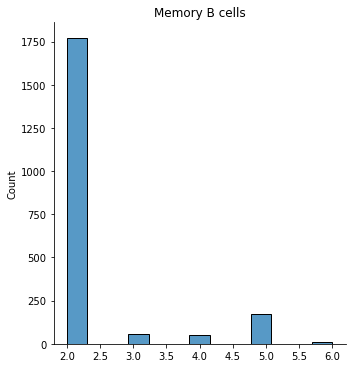



True positive naive B cell: 94.51264605827541%
{'Memory B cells': 320, 'ABCs': 20, 'DC2': 8, 'Tnaive/CM_CD4': 4, 'Plasmablasts': 3, 'NK_CD16+': 2, 'Cycling': 2, 'Pre-B': 2, 'Plasma cells': 2, 'Tnaive/CM_CD8': 1, 'ILC3': 1, 'Teffector/EM_CD4': 1, 'Tregs': 1, 'Tem/emra_CD8': 1, 'Classical monocytes': 1, 'Cycling T&NK': 1, 'NK_CD56bright_CD16-': 1}
2.1940700808625335


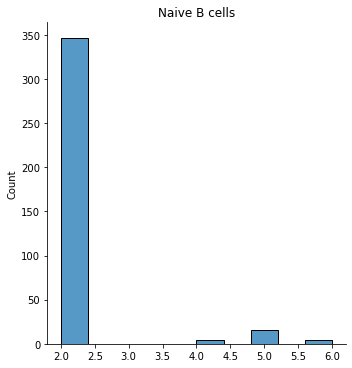



True positive T follicular helper cell: 27.386934673366838%
{'Tnaive/CM_CD4': 149, 'Teffector/EM_CD4': 85, 'Trm_Th1/Th17': 32, 'Tregs': 13, 'Tnaive/CM_CD8': 7, 'Trm_gut_CD8': 1, 'T_CD4/CD8': 1, 'MAIT': 1}
2.58477508650519


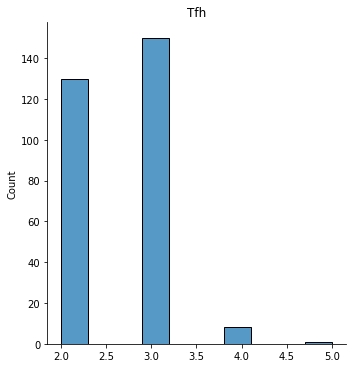



True positive plasma cell: 58.47553053269814%
{'Plasmablasts': 4150, 'NK_CD16+': 510, 'NK_CD56bright_CD16-': 32, 'Memory B cells': 13, 'Cycling': 12, 'ILC3': 11, 'Trm/em_CD8': 9, 'Cycling T&NK': 7, 'Alveolar macrophages': 6, 'ABCs': 5, 'Teffector/EM_CD4': 5, 'Naive B cells': 4, 'Trm_Th1/Th17': 4, 'GC_B (I)': 3, 'T_CD4/CD8': 3, 'Pro-B': 3, 'Intestinal macrophages': 3, 'Tem/emra_CD8': 3, 'Pre-B': 2, 'Classical monocytes': 2, 'Trm_Tgd': 2, 'MAIT': 1, 'Intermediate macrophages': 1, 'Nonclassical monocytes': 1, 'DC2': 1, 'Erythrophagocytic macrophages': 1}
2.3798498122653315


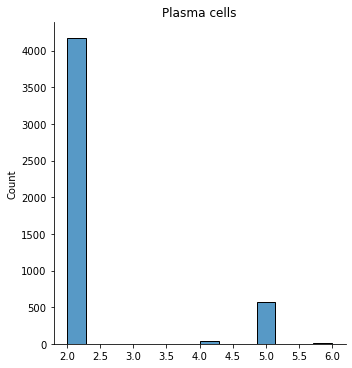



True positive regulatory T cell: 83.34612432847275%
{'Cycling T&NK': 63, 'Teffector/EM_CD4': 36, 'Tfh': 33, 'Tnaive/CM_CD4': 21, 'Memory B cells': 18, 'Trm/em_CD8': 12, 'Trm_Th1/Th17': 12, 'ILC3': 5, 'Tgd_CRTAM+': 4, 'T_CD4/CD8': 3, 'MAIT': 3, 'NK_CD56bright_CD16-': 2, 'Tnaive/CM_CD4_activated': 1, 'Classical monocytes': 1, 'Naive B cells': 1, 'Plasma cells': 1, 'Tnaive/CM_CD8': 1}
2.9815668202764978


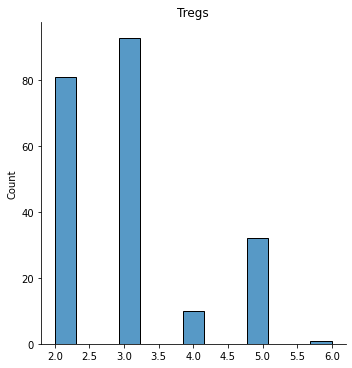



Logistic Regression


True positive memory B cell: 86.5335544781832%
{'Naive B cells': 910, 'ABCs': 692, 'DC2': 95, 'GC_B (I)': 84, 'Pro-B': 79, 'Tregs': 54, 'Plasmablasts': 37, 'GC_B (II)': 33, 'Plasma cells': 30, 'Tfh': 12, 'ILC3': 10, 'Tnaive/CM_CD4': 10, 'Trm/em_CD8': 8, 'Tnaive/CM_CD8': 7, 'T_CD4/CD8': 6, 'Cycling': 6, 'Cycling T&NK': 6, 'migDC': 6, 'Classical monocytes': 5, 'Teffector/EM_CD4': 4, 'Erythrophagocytic macrophages': 4, 'Alveolar macrophages': 3, 'Tem/emra_CD8': 3, 'Pre-B': 3, 'DC1': 2, 'Trm_Th1/Th17': 1, 'Intermediate macrophages': 1}
2.396020843202274


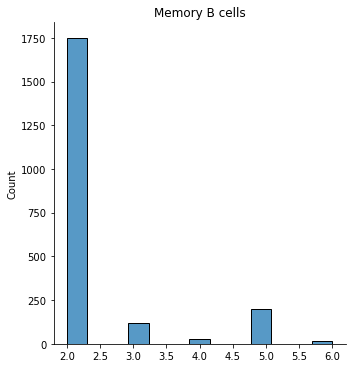



True positive naive B cell: 94.71971601834048%
{'Memory B cells': 318, 'ABCs': 13, 'Tnaive/CM_CD4': 5, 'Pro-B': 4, 'DC2': 3, 'GC_B (I)': 2, 'Classical monocytes': 2, 'Plasmablasts': 2, 'Tnaive/CM_CD8': 1, 'Trm/em_CD8': 1, 'NK_CD16+': 1, 'Tem/emra_CD8': 1, 'GC_B (II)': 1, 'Tregs': 1, 'Cycling': 1, 'Plasma cells': 1}
2.156862745098039


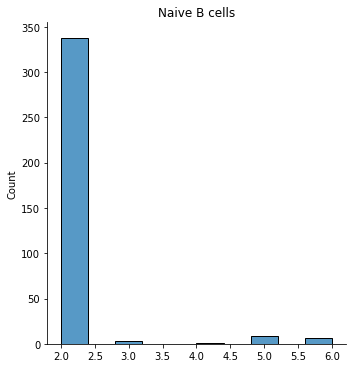



True positive T follicular helper cell: 28.391959798994975%
{'Tnaive/CM_CD4': 154, 'Teffector/EM_CD4': 84, 'Trm_Th1/Th17': 26, 'Tregs': 9, 'Tnaive/CM_CD8': 7, 'Trm_gut_CD8': 3, 'T_CD4/CD8': 1, 'Trm/em_CD8': 1}
2.635087719298246


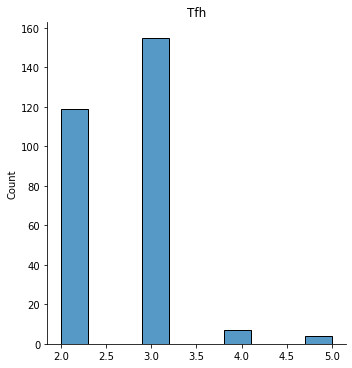



True positive plasma cell: 59.02122130792551%
{'Plasmablasts': 4076, 'NK_CD16+': 507, 'NK_CD56bright_CD16-': 32, 'Cycling': 18, 'GC_B (I)': 15, 'Memory B cells': 14, 'DC2': 11, 'ILC3': 8, 'Classical monocytes': 6, 'ABCs': 5, 'Tem/emra_CD8': 5, 'Cycling T&NK': 5, 'Alveolar macrophages': 5, 'Tnaive/CM_CD4': 3, 'Trm_Th1/Th17': 3, 'Intestinal macrophages': 3, 'Erythrophagocytic macrophages': 3, 'Naive B cells': 2, 'T_CD4/CD8': 2, 'Tregs': 1, 'Pro-B': 1, 'GC_B (II)': 1, 'Teffector/EM_CD4': 1, 'MAIT': 1, 'DC1': 1, 'Trm/em_CD8': 1, 'Intermediate macrophages': 1}
2.3885013739167196


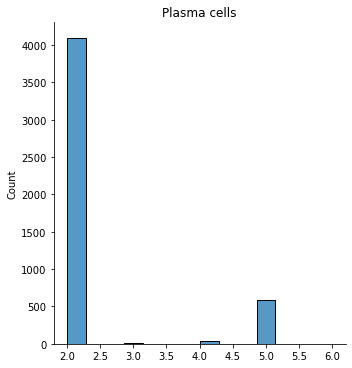



True positive regulatory T cell: 83.49961627014582%
{'Cycling T&NK': 61, 'Tfh': 43, 'Teffector/EM_CD4': 31, 'Tnaive/CM_CD4': 26, 'Trm/em_CD8': 11, 'Memory B cells': 9, 'Trm_Th1/Th17': 9, 'Pro-B': 8, 'MAIT': 4, 'Tgd_CRTAM+': 3, 'ILC3': 3, 'Tnaive/CM_CD4_activated': 2, 'Naive B cells': 1, 'Classical monocytes': 1, 'NK_CD56bright_CD16-': 1, 'Plasma cells': 1, 'Tnaive/CM_CD8': 1}
2.9488372093023254


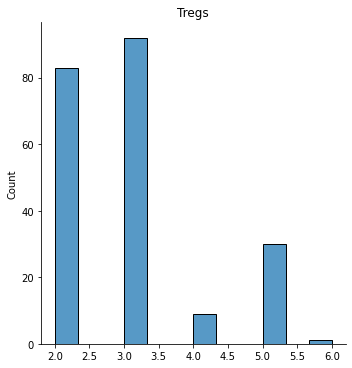



kNN


True positive memory B cell: 91.57310538402653%
{'Naive B cells': 733, 'ABCs': 215, 'Plasmablasts': 63, 'GC_B (I)': 51, 'Tregs': 43, 'DC2': 37, 'GC_B (II)': 28, 'Teffector/EM_CD4': 21, 'Plasma cells': 21, 'Classical monocytes': 16, 'Tnaive/CM_CD4': 13, 'T_CD4/CD8': 12, 'ILC3': 11, 'Tfh': 11, 'Tem/emra_CD8': 10, 'Cycling T&NK': 7, 'Cycling': 6, 'Tnaive/CM_CD8': 6, 'Trm/em_CD8': 5, 'Erythrophagocytic macrophages': 5, 'Pro-B': 3, 'migDC': 2, 'Intestinal macrophages': 1, 'Tnaive/CM_CD4_activated': 1}
2.5170325510976532


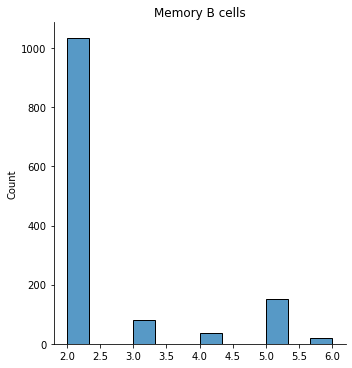



True positive naive B cell: 92.5159000147907%
{'Memory B cells': 481, 'Classical monocytes': 5, 'Tem/emra_CD8': 4, 'Tnaive/CM_CD4': 4, 'ABCs': 3, 'Plasmablasts': 3, 'NK_CD16+': 2, 'Tnaive/CM_CD8': 1, 'T_CD4/CD8': 1, 'GC_B (I)': 1, 'Plasma cells': 1}
2.108695652173913


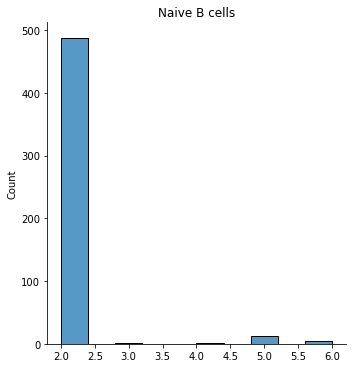



True positive T follicular helper cell: 23.869346733668344%
{'Tnaive/CM_CD4': 191, 'Teffector/EM_CD4': 57, 'Trm_Th1/Th17': 18, 'Tregs': 16, 'Tnaive/CM_CD8': 11, 'T_CD4/CD8': 6, 'Trm_gut_CD8': 2, 'MAIT': 2}
2.7557755775577557


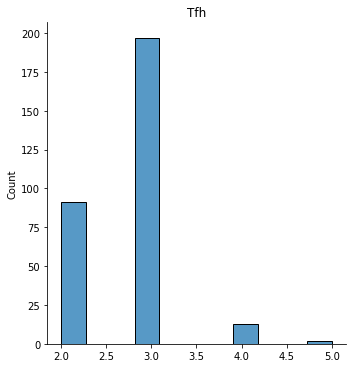



True positive plasma cell: 57.58336942399307%
{'Plasmablasts': 4250, 'NK_CD16+': 526, 'T_CD4/CD8': 17, 'Tem/emra_CD8': 17, 'NK_CD56bright_CD16-': 15, 'Memory B cells': 11, 'Alveolar macrophages': 11, 'Cycling T&NK': 8, 'GC_B (I)': 6, 'DC2': 6, 'Trm/em_CD8': 5, 'Naive B cells': 4, 'ABCs': 4, 'Classical monocytes': 4, 'Cycling': 2, 'Trm_Th1/Th17': 2, 'Intestinal macrophages': 2, 'Erythrophagocytic macrophages': 2, 'GC_B (II)': 1, 'Tgd_CRTAM+': 1, 'ILC3': 1, 'Teffector/EM_CD4': 1, 'Tregs': 1}
2.3771696957320807


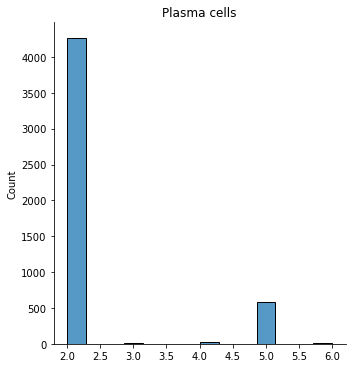



True positive regulatory T cell: 73.67613200306984%
{'Tfh': 96, 'Tnaive/CM_CD4': 71, 'Cycling T&NK': 64, 'Teffector/EM_CD4': 36, 'Memory B cells': 26, 'Trm/em_CD8': 12, 'Trm_Th1/Th17': 8, 'MAIT': 7, 'T_CD4/CD8': 5, 'Tem/emra_CD8': 4, 'Tnaive/CM_CD4_activated': 3, 'Tgd_CRTAM+': 3, 'ILC3': 3, 'Tnaive/CM_CD8': 2, 'Naive B cells': 1, 'Classical monocytes': 1, 'NK_CD56bright_CD16-': 1}
2.877551020408163


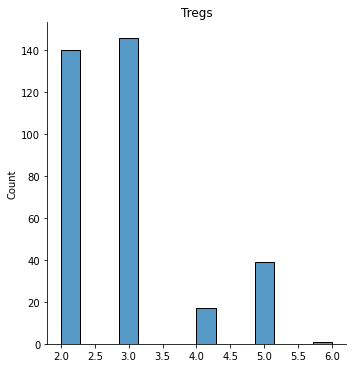

In [19]:
print("OUR MODEL")
wrong_dict_our_model_list = []
for i in range(len(train_celltypes)):
    print('\n')
    wrong_dict_our_model = helper_fns.print_true_positive_given_labels_and_datasets(test_true_labels=dataset_popv_pca.obs['cell_type'], test_pred_labels=test_preds, 
        train_celltype=train_celltypes[i], test_celltype=test_celltypes[i])
    plot_dist_histogram(wrong_dict_our_model, g, list_ct, list_inner_nodes, encoder_celltype, encoder_celltype_inner, save=False, model='our_model')
    wrong_dict_our_model_list.append(wrong_dict_our_model)

print('\n')
print("Logistic Regression")
wrong_dict_logistic_regression_list = []
test_preds_logistic = encoder_celltype.inverse_transform(model_logistic.predict(dataset_popv_pca.X))
for i in range(len(train_celltypes)):
    print('\n')
    wrong_dict_logistic = helper_fns.print_true_positive_given_labels_and_datasets(test_true_labels=dataset_popv_pca.obs['cell_type'], test_pred_labels=test_preds_logistic, 
        train_celltype=train_celltypes[i], test_celltype=test_celltypes[i])
    plot_dist_histogram(wrong_dict_logistic, g, list_ct, list_inner_nodes, encoder_celltype, encoder_celltype_inner, save=False, model='logistic_regression')
    wrong_dict_logistic_regression_list.append(wrong_dict_logistic)

print('\n')
print("kNN")
wrong_dict_knn_list = []
test_preds_knn = encoder_celltype.inverse_transform(model_knn.predict(dataset_popv_pca.X))
for i in range(len(train_celltypes)):
    print('\n')
    wrong_pred_knn = helper_fns.print_true_positive_given_labels_and_datasets(test_true_labels=dataset_popv_pca.obs['cell_type'], test_pred_labels=test_preds_knn, 
        train_celltype=train_celltypes[i], test_celltype=test_celltypes[i])
    plot_dist_histogram(wrong_pred_knn, g, list_ct, list_inner_nodes, encoder_celltype, encoder_celltype_inner, save=False, model='knn')
    wrong_dict_knn_list.append(wrong_pred_knn)

In [21]:
df_acc = pd.DataFrame(columns=['celltype', 'true_positive_rate', 'model'])
for i in range(len(wrong_dict_our_model_list)):
    # Fill temp_df with the true positive rate for each cell type using pd.concat
    a = pd.DataFrame({
        'celltype': [wrong_dict_our_model_list[i]['Celltype'], wrong_dict_logistic_regression_list[i]['Celltype'], wrong_dict_knn_list[i]['Celltype']],
        'true_positive_rate': [wrong_dict_our_model_list[i]['true_positive_rate'], wrong_dict_logistic_regression_list[i]['true_positive_rate'], wrong_dict_knn_list[i]['true_positive_rate']],
        'model': ['our_model', 'logistic_regression', 'knn']
        })
    df_acc = pd.concat([df_acc, a], ignore_index=True)

In [26]:
# Save igraph object g
g.write_pickle('./results_0908/g.pkl')

In [28]:
len(cv[0]['train'])

255030

In [22]:
df_dist = pd.DataFrame(columns=['celltype', 'pred_celltype', 'dist', 'model'])
for n in range(len(wrong_dict_our_model_list)):
    for key in wrong_dict_our_model_list[n].keys():
        celltype = wrong_dict_our_model_list[n]['Celltype']
        if key != 'Celltype' and key != 'true_positive_rate':
            num = int(wrong_dict_our_model_list[n][key])
            dist = helper_fns.get_shortest_dist(helper_fns.transform(key, list_ct, list_inner_nodes, encoder_celltype, encoder_celltype_inner), 
            helper_fns.transform(celltype, list_ct, list_inner_nodes, encoder_celltype, encoder_celltype_inner), g)
            for i in range(num):
                # concat the new row to the dataframe
                df_dist = pd.concat([df_dist, pd.DataFrame([[celltype, key , dist, 'our_model']], columns=['celltype', 'pred_celltype', 'dist', 'model'])], ignore_index=True)

    for key in wrong_dict_logistic_regression_list[n].keys():
        celltype = wrong_dict_logistic_regression_list[n]['Celltype']
        if key != 'Celltype' and key != 'true_positive_rate':
            num = int(wrong_dict_logistic_regression_list[n][key])
            dist = helper_fns.get_shortest_dist(helper_fns.transform(key, list_ct, list_inner_nodes, encoder_celltype, encoder_celltype_inner), 
            helper_fns.transform(celltype, list_ct, list_inner_nodes, encoder_celltype, encoder_celltype_inner), g)
            for i in range(num):
                # concat the new row to the dataframe
                df_dist = pd.concat([df_dist, pd.DataFrame([[celltype, key , dist, 'logistic']], columns=['celltype', 'pred_celltype', 'dist', 'model'])], ignore_index=True)

    for key in wrong_dict_knn_list[n].keys():
        celltype = wrong_dict_knn_list[n]['Celltype']
        if key != 'Celltype' and key != 'true_positive_rate':
            num = int(wrong_dict_knn_list[n][key])
            dist = helper_fns.get_shortest_dist(helper_fns.transform(key, list_ct, list_inner_nodes, encoder_celltype, encoder_celltype_inner), 
            helper_fns.transform(celltype, list_ct, list_inner_nodes, encoder_celltype, encoder_celltype_inner), g)
            for i in range(num):
                # concat the new row to the dataframe
                df_dist = pd.concat([df_dist, pd.DataFrame([[celltype, key , dist, 'knn']], columns=['celltype', 'pred_celltype', 'dist', 'model'])], ignore_index=True)

In [24]:
# Save label encoder
with open('./results_0908/encoder_celltype.pickle', 'wb') as f:
    pickle.dump(encoder_celltype, f)

with open('./results_0908/encoder_celltype_inner.pickle', 'wb') as f:
    pickle.dump(encoder_celltype_inner, f)

# Save list_ct and list_inner_nodes
with open('./results_0908/list_ct.pickle', 'wb') as f:
    pickle.dump(list_ct, f)

with open('./results_0908/list_inner_nodes.pickle', 'wb') as f:
    pickle.dump(list_inner_nodes, f)

# Save the celltypist_graph
with open('./results_0908/celltypist_graph.pickle', 'wb') as f:
    pickle.dump(g, f)


In [23]:
mean_dist_our_model = [2.330293819655522, 2.1398416886543536, 2.671232876712329, 2.3760577915376677, 3.1973684210526314]
mean_dist_logistic = [2.567415730337079, 2.13986013986014, 2.6486486486486487, 2.4160771704180064, 3.0558375634517767]
mean_dist_knn = [2.4720048163756774, 2.0915805022156575, 2.6055555555555556, 2.2909618998804033, 3.0334075723830733]
df_mean_dist = pd.DataFrame(columns=['celltype', 'mean_dist', 'model'])
for i in range(len(mean_dist_our_model)):
    # Fill temp_df with the true positive rate for each cell type using pd.concat
    a = pd.DataFrame({
        'celltype': [wrong_dict_our_model_list[i]['Celltype'], wrong_dict_logistic_regression_list[i]['Celltype'], wrong_dict_knn_list[i]['Celltype']],
        'mean_dist': [mean_dist_our_model[i], mean_dist_logistic[i], mean_dist_knn[i]],
        'model': ['our_model', 'logistic_regression', 'knn']
        })
    df_mean_dist = pd.concat([df_mean_dist, a], ignore_index=True)

# train_err = [7.30, 8.498608006901154, 8.553111398658986]
# test_err = [8.80, 9.04954658131727, 11.832815588816715]
df_err = pd.DataFrame(columns=['error', 'model', 'type'])
a = pd.DataFrame({
    'error': [7.30, 8.80, 8.498608006901154, 9.04954658131727, 8.553111398658986, 11.832815588816715],
    'model': ['our_model', 'our_model', 'logistic_regression', 'logistic_regression', 'knn', 'knn'],
    'type': ['train', 'test', 'train', 'test', 'train', 'test']
    })
df_err = pd.concat([df_err, a], ignore_index=True)

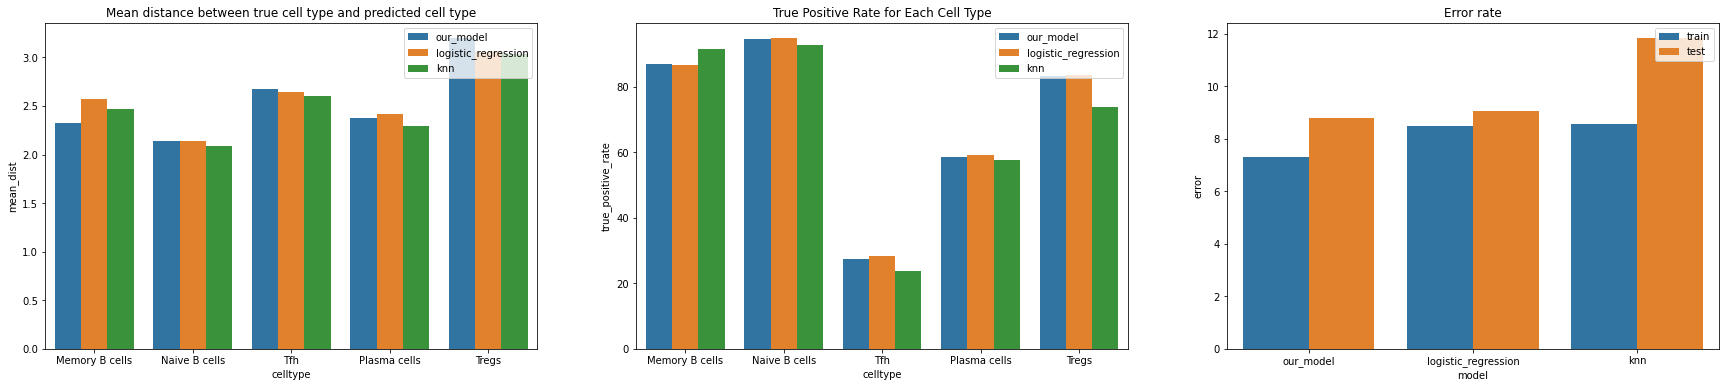

In [24]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30, 6))
sns.barplot(x='celltype', y='mean_dist', hue='model', data=df_mean_dist, ax=ax1)
ax1.set_title('Mean distance between true cell type and predicted cell type')
ax1.legend(loc='upper right')
ax2 = sns.barplot(data=df_acc, x='celltype', y='true_positive_rate', hue='model', ax=ax2)
ax2.set_title('True Positive Rate for Each Cell Type')
ax2.legend(loc='upper right')
ax3 = sns.barplot(data=df_err, x='model', y='error', hue='type', ax=ax3)
ax3.set_title('Error rate')
ax3.legend(loc='upper right')
plt.show()

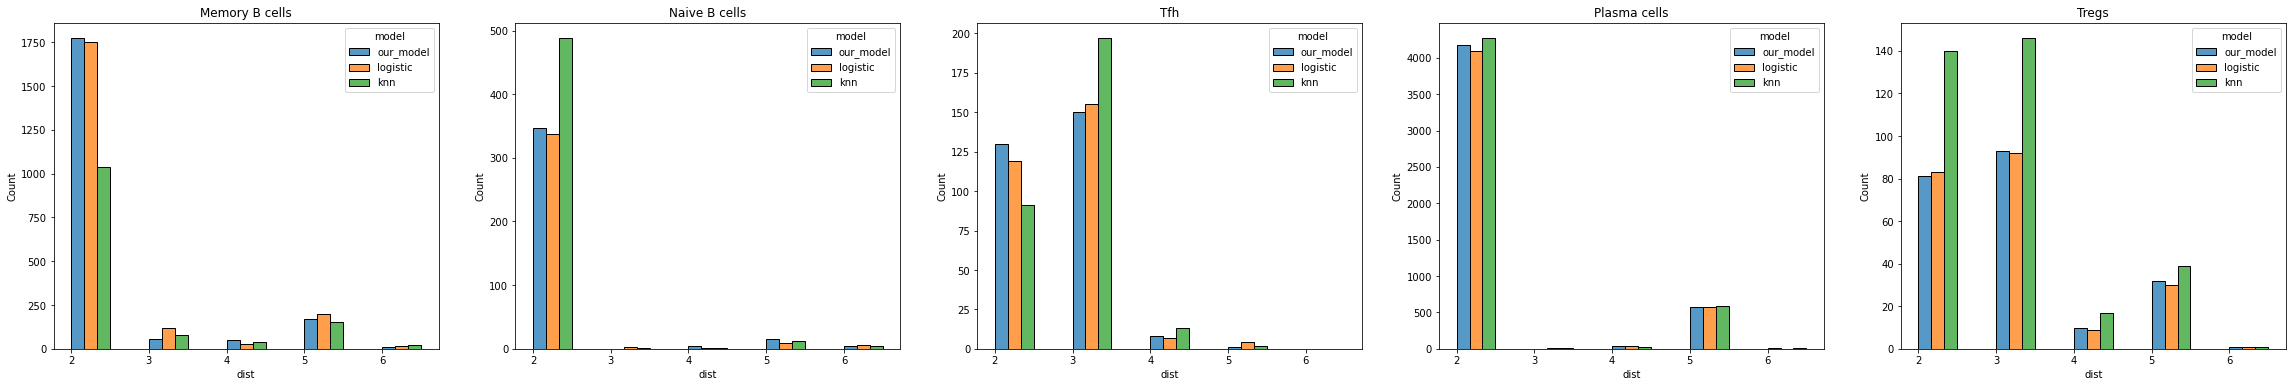

In [25]:
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5)
fig.set_size_inches(40, 6)
# ax0 = sns.barplot(data=df_acc, x='celltype', y='true_positive_rate', hue='model', ax=ax0)
# ax0.set_title('True Positive Rate for Each Cell Type')
# ax0.legend(loc='upper right')
sns.histplot(data=df_dist[df_dist['celltype'] == 'Memory B cells'], x="dist", multiple="dodge", hue="model", discrete=False, binwidth=0.5, binrange=(2,6.5), ax=ax1)
ax1.set_title('Memory B cells')
sns.histplot(data=df_dist[df_dist['celltype'] == 'Naive B cells'], x="dist", multiple="dodge", hue="model", discrete=False, binwidth=0.5, binrange=(2,6.5), ax=ax2)
ax2.set_title('Naive B cells')
sns.histplot(data=df_dist[df_dist['celltype'] == 'Tfh'], x="dist", multiple="dodge", hue="model", discrete=False, binwidth=0.5, binrange=(2,6.5), ax=ax3)
ax3.set_title('Tfh')
sns.histplot(data=df_dist[df_dist['celltype'] == 'Plasma cells'], x="dist", multiple="dodge", hue="model", discrete=False, binwidth=0.5, binrange=(2,6.5), ax=ax4)
ax4.set_title('Plasma cells')
sns.histplot(data=df_dist[df_dist['celltype'] == 'Tregs'], x="dist", multiple="dodge", hue="model", discrete=False, binwidth=0.5, binrange=(2,6.5), ax=ax5)
ax5.set_title('Tregs')
plt.show()